### Data

In [106]:
import pandas as pd
import numpy as np

data = pd.read_csv("./bml-component-data.csv")

# Scale time column
data["timestamp"] /= 10000
data = data.drop(columns=["index"])

In [107]:
def pad(array, target_length):
    """Pads 1D array to target length using -1 constant as padding."""

    n_pad = target_length - array.shape[0]
    return np.pad(array, (0, n_pad), mode="constant", constant_values=[-1])

In [108]:
# Collect all values from each CX into one row and put timestamps and efficiencies into np arrays
data_grouped = data.groupby(["ID"]).agg(list)
data_grouped = data_grouped.map(np.array)

# Each row is exactly one CX
x = list(data_grouped["timestamp"])
y = list(data_grouped["efficiency"])

# Rows are ragged (rows aren't all the same length) so padding is required
max_obs = max([len(row) for row in y])

x_padded = np.array([pad(row, max_obs) for row in x])
y_padded = np.array([pad(row, max_obs) for row in y])

# Generate mask (True for actual values, False for padded values)
mask = x_padded != -1

In [109]:
# Generate M1 to M5 arrays. Each M value is the same for all measurements within a CX component
M_df = data.drop_duplicates(subset=["ID"])

# M[0] is all M1 values, M[1] is all M2 values etc.
M = np.array([M_df["M1"], M_df["M2"], M_df["M3"], M_df["M4"], M_df["M5"]])

### Enhanced Model

Model the efficiency $y_i$ as a noisy exponential decay function $f_i$, with parameters $u_i$, $v_i$ and $w_i$:

$$y_i(t) = f_i(t) + \epsilon$$

$$f_i(t) = u_i \cdot \exp \left \{-\left (v_i + \sum \limits _{j=1} ^5 w_j m_{ji}\right ) t \right \}$$

We omit the 10,000 divisor since we already divided the timestamp earlier.

In [ ]:
import numpyro as npr
import numpyro.distributions as dist
import jax.numpy as jnp

def model(t, y, m, mask):
    sigma = npr.sample("sigma", dist.HalfNormal(1))

    # Generate u_i and v_i for all CX components
    with npr.plate("cx-component", t.shape[0]):
        u = npr.sample("u", dist.Normal(90, 10))
        # Reduce mean and variance for v's hyperprior: spec says it is expected to be lower due to inclusion of w weights
        v = npr.sample("v", dist.Normal(3, 1))

    # Generate a weight for each M component
    with npr.plate("m", m.shape[0]):
        w = npr.sample("w", dist.Normal(0, 1))

    # Make predictions of f_i(t) then sample from normal dist with variance sigma to account for noise
    with npr.plate("observations", t.shape[1]):
        with npr.handlers.mask(mask=mask):
            m_sum = -(v + jnp.matmul(w, m))
            f = u[:, jnp.newaxis] * jnp.exp(m_sum[:, jnp.newaxis] * t)
            npr.sample("obs", dist.Normal(f, sigma), y)

In [111]:
from jax import random
from numpyro.infer import MCMC, NUTS

seed = 1
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(seed)
mcmc.run(rng_key, t=x_padded, y=y_padded, m=M, mask=mask)
mcmc.print_summary()

C:\Users\jayde\AppData\Local\Temp\ipykernel_404\584995192.py:8: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  mcmc.run(rng_key, t=x_padded, y=y_padded, m=M, mask=mask)
sample: 100%|██████████| 1500/1500 [00:04<00:00, 316.66it/s, 63 steps of size 9.04e-02. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      5.07      0.14      5.07      4.86      5.31   1546.08      1.00
      u[0]     92.09      2.46     92.11     87.97     95.98   2012.27      1.00
      u[1]     91.81      2.60     91.80     87.83     96.59   2483.46      1.00
      u[2]     92.86      2.79     92.78     88.15     97.18   1910.54      1.00
      u[3]     91.70      4.01     91.54     85.30     98.11   1773.85      1.00
      u[4]     90.03      4.05     90.04     83.50     96.56   1606.74      1.00
      u[5]     94.19      5.74     94.14     84.53    102.95   1155.95      1.00
      u[6]     91.50      4.63     91.40     84.40     99.12   2371.06      1.00
      u[7]     90.91      4.38     90.88     84.45     97.91   2128.81      1.00
      u[8]    103.11      4.07    103.12     96.44    109.60   2757.37      1.00
      u[9]     88.81      4.74     88.88     81.27     96.79   2160.70      1.00
     u[10]     99.88      3

In [112]:
samples = mcmc.get_samples()

jnp.abs(samples["v"]).mean()

Array(2.826137, dtype=float32)

### Visualisation

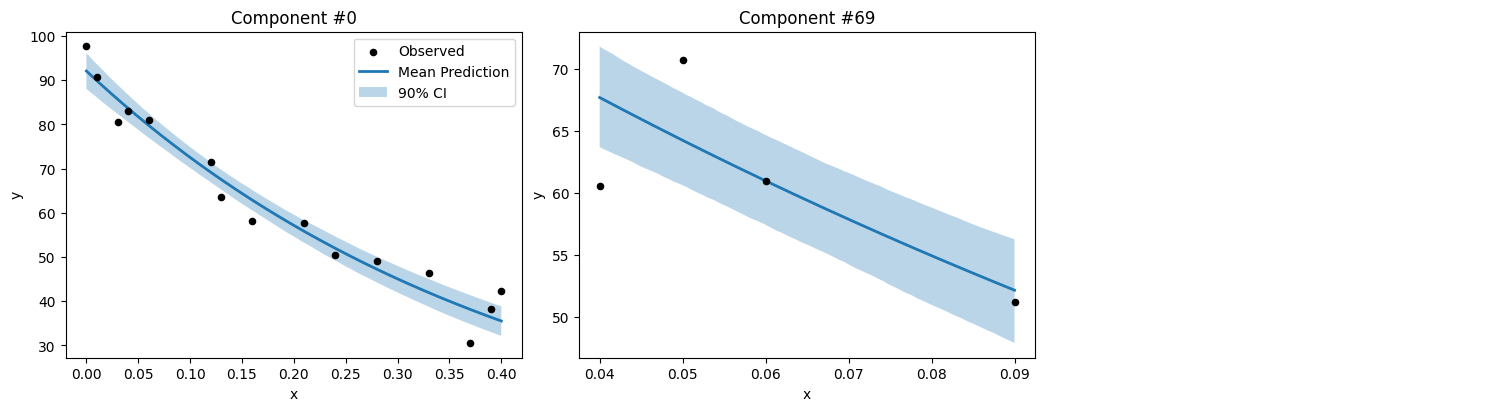

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

def plot_component_fits(mcmc, x_data, y_data, mask, M, plot_indices=None):
    """
    Plots observed data vs inferred decay curves with 90% CI for specific components.
    
    Args:
        mcmc: The fitted NumPyro MCMC object.
        x_data: The padded x input array.
        y_data: The padded y observed array.
        mask: The boolean mask array.
        M: The covariate matrix.
        plot_indices: A list or array of integer indices specifying which components to plot.
                      (e.g., [0, 5, 12]). If None, plots the first 6.
    """
    # 0. Handle Indices
    if plot_indices is None:
        plot_indices = np.arange(min(6, x_data.shape[0]))
    else:
        plot_indices = np.array(plot_indices)
        
    num_plots = len(plot_indices)

    # 1. Get posterior samples
    samples = mcmc.get_samples()
    u = samples['u']        # (num_samples, N)
    v = samples['v']        # (num_samples, N)
    w = samples['w']        # (num_samples, K)

    # 2. Handle M Matrix Shape (Auto-transpose if needed)
    # w is (Samples, K). We need M to be (K, N) to get (Samples, N).
    # If M is passed as (N, K), we transpose it.
    n_features = w.shape[-1]
    if M.shape[0] != n_features and M.shape[-1] == n_features:
        M = M.T

    # 3. Compute full interaction for all components
    # w: (S, K) @ M: (K, N) -> m_effect: (S, N)
    m_effect = jnp.dot(w, M)       
    
    # Calculate decay rate: -(v + m_effect) 
    # (Assuming we are keeping the negative sign logic from the model)
    m_sum = -(v + m_effect)

    # 4. Setup Plot Grid
    cols = 3
    rows = (num_plots + cols - 1) // cols
    # Ensure at least 1 row and 1 col even if list is empty
    rows = max(1, rows)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), constrained_layout=True)
    
    if num_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    # 5. Loop through specific indices
    for i, ax_idx in zip(range(num_plots), range(len(axes))):
        
        # Get the real component index from the user's list
        comp_idx = plot_indices[i]
        ax = axes[ax_idx]

        # --- A. Prepare Real Data ---
        valid_idx = mask[comp_idx].astype(bool)
        x_real = x_data[comp_idx][valid_idx]
        y_real = y_data[comp_idx][valid_idx]

        sort_order = np.argsort(x_real)
        x_real = x_real[sort_order]
        y_real = y_real[sort_order]

        # --- B. Generate Prediction ---
        # Smooth X axis for the line
        if len(x_real) > 0:
            x_smooth = jnp.linspace(x_real.min(), x_real.max(), 200)
        else:
            x_smooth = jnp.linspace(0, 10, 200)

        # Extract posterior samples for this specific component
        u_i = u[:, comp_idx]      # (samples,)
        m_i = m_sum[:, comp_idx]  # (samples,)

        # Compute predictions: u * exp(rate * x)
        predictions = u_i[:, None] * jnp.exp(m_i[:, None] * x_smooth)

        mean_pred = jnp.mean(predictions, axis=0)
        hpdi_low = jnp.percentile(predictions, 5, axis=0)
        hpdi_high = jnp.percentile(predictions, 95, axis=0)

        # --- C. Plot ---
        ax.scatter(x_real, y_real, color='black', s=20, label='Observed', zorder=3)
        ax.plot(x_smooth, mean_pred, lw=2, label='Mean Prediction')
        ax.fill_between(x_smooth, hpdi_low, hpdi_high, alpha=0.3, label='90% CI')

        ax.set_title(f"Component #{comp_idx}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")

        if i == 0:
            ax.legend()

    # Hide unused subplots
    for j in range(num_plots, len(axes)):
        axes[j].axis('off')

    plt.show()

plot_component_fits(mcmc, x_padded, y_padded, mask, M=M, plot_indices=[0, 69])

### Blind Predictions

Predict probability over all 1000 samples and average.



In [121]:
import jax.scipy.stats as stats

def predict_probability_below(samples, component: int, m: np.array, t: float = 40.0, y: float = 35.0):
    """
    Returns predicted probability of a component being below
    efficiency `y` at time `t`.
    """
    t /= 10_000

    # Get the component's M1 to M5 values
    m_component = m[:, component]

    # Get samples from the component
    s = samples["sigma"]
    u = samples["u"][:, component]
    v = samples["v"][:, component]
    w = samples["w"]

    m_sum = -(v + jnp.matmul(w, m_component))
    f = u * jnp.exp(m_sum * t)

    # Use cumulative dist function to get probability of predicted efficiency being under `y`
    probs = stats.norm.cdf(y, loc=f, scale=s)

    return probs.mean()


predict_probability_below(samples, component=68, m=M)

Array(4.4521203e-17, dtype=float32)